In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_curve, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score

In [3]:
modern = pd.read_csv("modern_met_fe.csv")

In [4]:
modern.highlighted = modern.highlighted.apply(lambda x: 1 if x == True else 0)

In [5]:
X, y = modern.iloc[:, 1:], modern.iloc[:, 0]

In [6]:
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=.25, random_state=4)

**Helper Functions**

In [36]:
def cross_val_model(model, X, y): 
    scores = cross_val_score(model, X, y, cv = 5, scoring='precision')
    print(f"Precision scores are: {scores}. Mean of precision scores is: {scores.mean()}")

In [26]:
def plot_for_threshold(model): 
    thresh_ps = np.linspace(.10,.50,1000)
    model_val_probs = model.predict_proba(X_train)[:,1] 

    f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
    for p in thresh_ps:
        model_val_labels = model_val_probs >= p
        f1_scores.append(f1_score(y_train, model_val_labels))    
        prec_scores.append(precision_score(y_train, model_val_labels))
        rec_scores.append(recall_score(y_train, model_val_labels))
        acc_scores.append(accuracy_score(y_train, model_val_labels))

    plt.plot(thresh_ps, f1_scores)
    plt.plot(thresh_ps, prec_scores)
    plt.plot(thresh_ps, rec_scores)
    plt.plot(thresh_ps, acc_scores)

    plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
    plt.legend(['F1','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left')
    plt.xlabel('P threshold')
    plt.ylabel('Metric score')

    best_f1_score = np.max(f1_scores) 
    best_prec_score = np.max(prec_scores)
    best_thresh_p = thresh_ps[np.argmax(prec_scores)]

    print('Logistic Regression Model best Precision score %.3f at prob decision threshold >= %.6f' 
          % (best_prec_score, best_thresh_p))

In [27]:
def model_scoring(model): 
    train_score = model.score(X_train, y_train)
    val_score = model.score(X_val, y_val)
    print(f"Generay train accuracy score: {train_score}, General validation accuracy score: {val_score}")
    
    model_precision = precision_score(y_val, y_predict_hard)
    model_recall = recall_score(y_val, y_predict_hard)
    model_f1 = f1_score(y_val, y_predict_hard)
    print("After adjusting for threshold -")
    print(f"Precision score: {model_precision}, Recall score: {model_recall}, F1 score: {model_f1}")

In [28]:
def model_confusion_matrix(model): 
    model_confusion = confusion_matrix(y_val, y_predict_hard)
    sns.heatmap(model_confusion, annot=True, \
                xticklabels=['not','highlighted'], yticklabels=['not','highlighted'])
    plt.xlabel('Highlighting Predicted')
    plt.ylabel('Highlighting Actual')

In [33]:
def model_curves(model): 
    y_predict_prob = model.predict_proba(X_train)
    y_predict_prob = y_predict_prob[:, 1]
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_train, y_predict_prob)
    plt.plot(threshold_curve, precision_curve[1:],label='precision')
    plt.plot(threshold_curve, recall_curve[1:], label='recall')
    plt.legend(loc='lower left')
    plt.xlabel('Threshold (above this probability, label as highlight-possible)');
    plt.title('Precision and Recall Curves for Modern Met')

    fpr, tpr, thresholds = roc_curve(y_train, y_predict_prob)
    plt.figure(dpi=80)
    plt.plot(fpr, tpr,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for predicting higlighting at the Met Modern Section')
    plt.savefig("ROC curve for predicting higlighting at the Met Modern Section.png", bbox_inches='tight');
    print("ROC AUC score = ", roc_auc_score(y_train, y_predict_prob))

## KNN

In [60]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [61]:
cross_val_model(knn, X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision scores are: [0.         0.         0.14285714 0.         0.66666667]. Mean of precision scores is: 0.1619047619047619


ROC AUC score =  0.9292440956145499


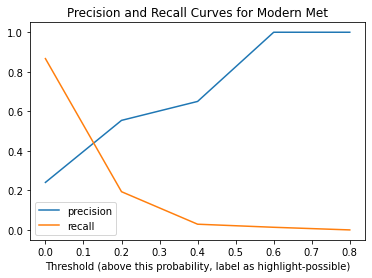

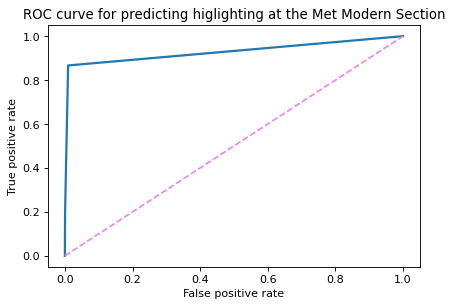

In [62]:
model_curves(knn) 

Logistic Regression Model best Precision score 0.650 at prob decision threshold >= 0.400300


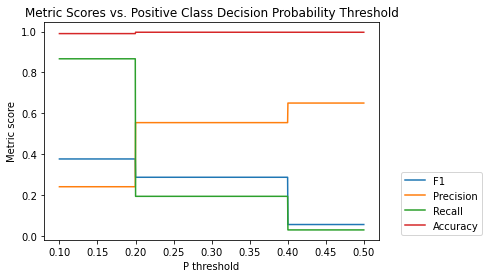

In [63]:
plot_for_threshold(knn)

In [64]:
y_predict_hard = (lr.predict_proba(X_val)[:,1] >= 0.400300).astype(bool) 

In [65]:
model_scoring(knn)

Generay train accuracy score: 0.996568487274807, General validation accuracy score: 0.9966612566658938
After adjusting for threshold -
Precision score: 1.0, Recall score: 0.19014084507042253, F1 score: 0.31952662721893493


In [66]:
cross_val_model(knn, X_val, y_val)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision scores are: [0. 0. 0. 0. 0.]. Mean of precision scores is: 0.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


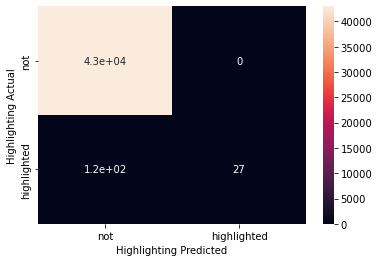

In [67]:
model_confusion_matrix(knn)

## LOG REG

In [30]:
lr = LogisticRegression(C=100, solver='liblinear', max_iter=500000)
lr.fit(X_train, y_train)

LogisticRegression(C=100, max_iter=500000, solver='liblinear')

In [37]:
cross_val_model(lr, X_train, y_train)

Precision scores are: [1. 1. 1. 1. 1.]. Mean of precision scores is: 1.0


ROC AUC score =  0.9379871446532425


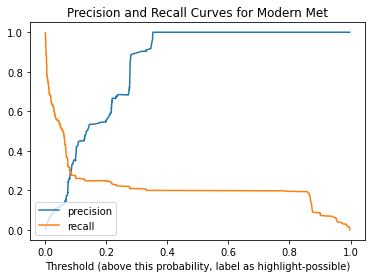

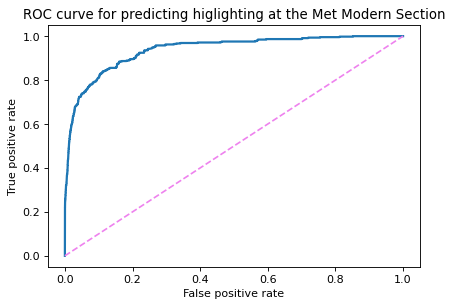

In [34]:
model_curves(lr) 

Logistic Regression Model best Precision score 1.000 at prob decision threshold >= 0.352653


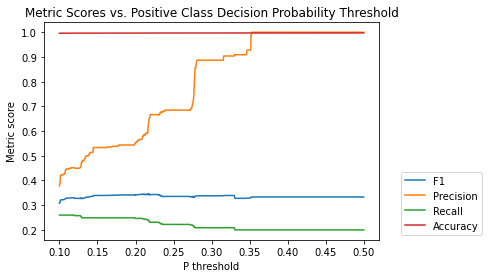

In [35]:
plot_for_threshold(lr)

In [40]:
y_predict_hard = (lr.predict_proba(X_val)[:,1] >= 0.352653).astype(bool) # set threshold as 0.352653

In [41]:
model_scoring(lr)

Generay train accuracy score: 0.9972176923849786, General validation accuracy score: 0.9973336424762347
After adjusting for threshold -
Precision score: 1.0, Recall score: 0.19014084507042253, F1 score: 0.31952662721893493


In [45]:
cross_val_model(lr, X_val, y_val)

Precision scores are: [1. 1. 1. 1. 1.]. Mean of precision scores is: 1.0


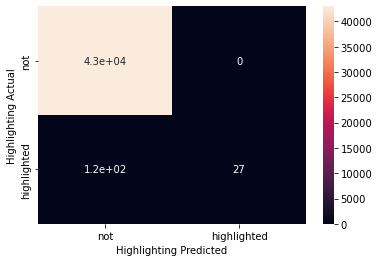

In [42]:
model_confusion_matrix(lr)

## RANDOM FOREST

In [43]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier()

In [44]:
cross_val_model(rf, X_train, y_train)

Precision scores are: [0.48076923 0.43137255 0.42105263 0.33333333 0.44444444]. Mean of precision scores is: 0.4221944378291127


ROC AUC score =  0.9977889286148229


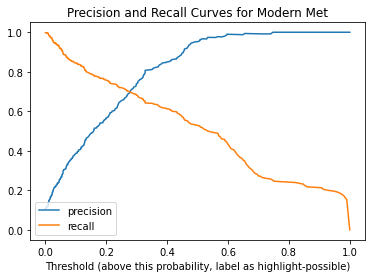

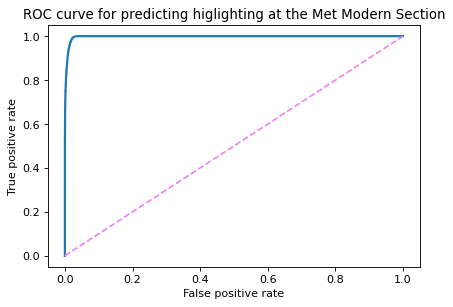

In [46]:
model_curves(rf) 

Logistic Regression Model best Precision score 0.952 at prob decision threshold >= 0.493193


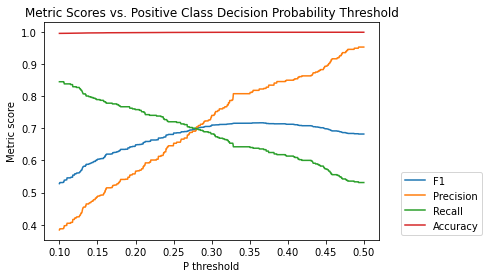

In [47]:
plot_for_threshold(rf)

In [48]:
y_predict_hard = (rf.predict_proba(X_val)[:,1] >= 0.491592).astype(bool) 

In [49]:
model_scoring(rf)

Generay train accuracy score: 0.9982687863728756, General validation accuracy score: 0.996498956642708
After adjusting for threshold -
Precision score: 0.44871794871794873, Recall score: 0.24647887323943662, F1 score: 0.3181818181818182


In [50]:
cross_val_score(rf, X_val, y_val)

array([0.99571064, 0.99571064, 0.9959425 , 0.99652214, 0.99652214])

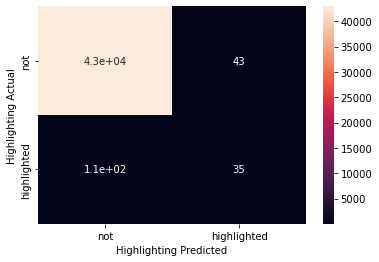

In [51]:
model_confusion_matrix(rf)

## DECISION TREE

In [52]:
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [53]:
cross_val_model(dt, X_train, y_train)

Precision scores are: [1.         1.         1.         0.93333333 1.        ]. Mean of precision scores is: 0.9866666666666667


ROC AUC score =  0.823467134760537


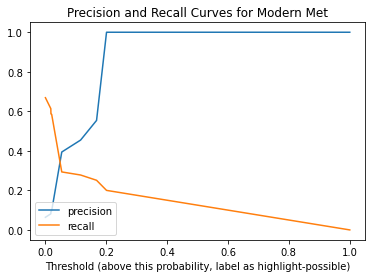

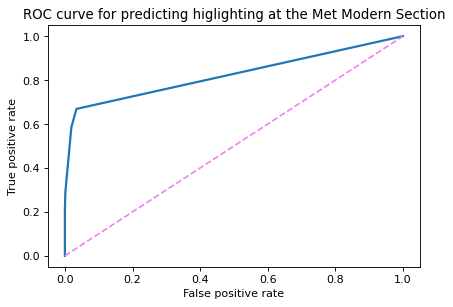

In [54]:
model_curves(dt) 

Logistic Regression Model best Precision score 1.000 at prob decision threshold >= 0.202102


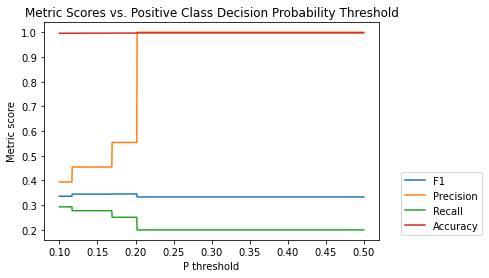

In [55]:
plot_for_threshold(dt)

In [56]:
y_predict_hard = (dt.predict_proba(X_val)[:,1] >= 0.202102).astype(bool) 

In [57]:
model_scoring(dt)

Generay train accuracy score: 0.9972176923849786, General validation accuracy score: 0.9973336424762347
After adjusting for threshold -
Precision score: 1.0, Recall score: 0.19014084507042253, F1 score: 0.31952662721893493


In [58]:
cross_val_score(dt, X_val, y_val)

array([0.99710179, 0.99710179, 0.99733364, 0.99779736, 0.99710179])

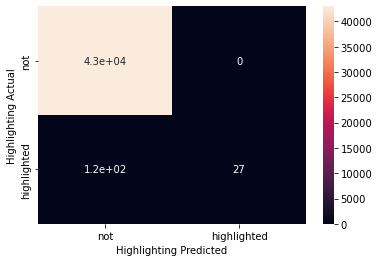

In [59]:
model_confusion_matrix(dt)